In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effictively.

In [4]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [5]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [6]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [7]:
file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [8]:
file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


## Train detector

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')
    




Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [5/209] Loss: 6.9127, average_loss: 6.6488
Epoch [1/50], Iter [10/209] Loss: 8.3162, average_loss: 7.3453
Epoch [1/50], Iter [15/209] Loss: 7.9235, average_loss: 7.1496
Epoch [1/50], Iter [20/209] Loss: 6.0563, average_loss: 6.9251
Epoch [1/50], Iter [25/209] Loss: 5.4735, average_loss: 6.8477
Epoch [1/50], Iter [30/209] Loss: 5.8511, average_loss: 6.8371
Epoch [1/50], Iter [35/209] Loss: 4.8827, average_loss: 6.6834
Epoch [1/50], Iter [40/209] Loss: 6.4263, average_loss: 6.6842
Epoch [1/50], Iter [45/209] Loss: 6.3230, average_loss: 6.5934
Epoch [1/50], Iter [50/209] Loss: 6.2758, average_loss: 6.5379
Epoch [1/50], Iter [55/209] Loss: 6.0874, average_loss: 6.5327
Epoch [1/50], Iter [60/209] Loss: 7.5618, average_loss: 6.5453
Epoch [1/50], Iter [65/209] Loss: 5.0466, average_loss: 6.5223
Epoch [1/50], Iter [70/209] Loss: 4.2761, average_loss: 6.4510
Epoch [1/50], Iter [75/209] Loss: 6.5779, average_loss: 6.4

Epoch [4/50], Iter [10/209] Loss: 4.0581, average_loss: 3.9912
Epoch [4/50], Iter [15/209] Loss: 3.7873, average_loss: 3.9215
Epoch [4/50], Iter [20/209] Loss: 3.4487, average_loss: 3.8940
Epoch [4/50], Iter [25/209] Loss: 3.9649, average_loss: 3.9015
Epoch [4/50], Iter [30/209] Loss: 2.9058, average_loss: 3.8670
Epoch [4/50], Iter [35/209] Loss: 4.3156, average_loss: 3.9132
Epoch [4/50], Iter [40/209] Loss: 4.2264, average_loss: 3.9792
Epoch [4/50], Iter [45/209] Loss: 3.1267, average_loss: 3.9877
Epoch [4/50], Iter [50/209] Loss: 4.5219, average_loss: 3.9655
Epoch [4/50], Iter [55/209] Loss: 3.4018, average_loss: 3.9907
Epoch [4/50], Iter [60/209] Loss: 3.4384, average_loss: 3.9675
Epoch [4/50], Iter [65/209] Loss: 3.1954, average_loss: 3.9179
Epoch [4/50], Iter [70/209] Loss: 5.7646, average_loss: 3.9666
Epoch [4/50], Iter [75/209] Loss: 3.2860, average_loss: 3.9323
Epoch [4/50], Iter [80/209] Loss: 4.1527, average_loss: 3.9183
Epoch [4/50], Iter [85/209] Loss: 4.7113, average_loss:

Epoch [7/50], Iter [20/209] Loss: 3.3800, average_loss: 3.4302
Epoch [7/50], Iter [25/209] Loss: 4.1685, average_loss: 3.3969
Epoch [7/50], Iter [30/209] Loss: 3.6743, average_loss: 3.3564
Epoch [7/50], Iter [35/209] Loss: 3.1016, average_loss: 3.3653
Epoch [7/50], Iter [40/209] Loss: 4.1850, average_loss: 3.3376
Epoch [7/50], Iter [45/209] Loss: 3.5092, average_loss: 3.3307
Epoch [7/50], Iter [50/209] Loss: 4.0338, average_loss: 3.3232
Epoch [7/50], Iter [55/209] Loss: 3.3363, average_loss: 3.3413
Epoch [7/50], Iter [60/209] Loss: 3.3576, average_loss: 3.3446
Epoch [7/50], Iter [65/209] Loss: 3.0532, average_loss: 3.3564
Epoch [7/50], Iter [70/209] Loss: 2.7894, average_loss: 3.3422
Epoch [7/50], Iter [75/209] Loss: 4.0323, average_loss: 3.3457
Epoch [7/50], Iter [80/209] Loss: 2.7562, average_loss: 3.3454
Epoch [7/50], Iter [85/209] Loss: 3.2659, average_loss: 3.3240
Epoch [7/50], Iter [90/209] Loss: 2.9586, average_loss: 3.3468
Epoch [7/50], Iter [95/209] Loss: 2.9501, average_loss:

Epoch [10/50], Iter [30/209] Loss: 2.9001, average_loss: 2.8212
Epoch [10/50], Iter [35/209] Loss: 2.9376, average_loss: 2.7946
Epoch [10/50], Iter [40/209] Loss: 2.2703, average_loss: 2.8138
Epoch [10/50], Iter [45/209] Loss: 2.6904, average_loss: 2.8000
Epoch [10/50], Iter [50/209] Loss: 2.8630, average_loss: 2.8308
Epoch [10/50], Iter [55/209] Loss: 3.0873, average_loss: 2.8501
Epoch [10/50], Iter [60/209] Loss: 3.7846, average_loss: 2.9073
Epoch [10/50], Iter [65/209] Loss: 2.6809, average_loss: 2.9056
Epoch [10/50], Iter [70/209] Loss: 3.4261, average_loss: 2.8846
Epoch [10/50], Iter [75/209] Loss: 3.8275, average_loss: 2.8967
Epoch [10/50], Iter [80/209] Loss: 3.1042, average_loss: 2.9064
Epoch [10/50], Iter [85/209] Loss: 3.1985, average_loss: 2.8969
Epoch [10/50], Iter [90/209] Loss: 3.4973, average_loss: 2.9211
Epoch [10/50], Iter [95/209] Loss: 2.5874, average_loss: 2.9219
Epoch [10/50], Iter [100/209] Loss: 2.2997, average_loss: 2.9168
Epoch [10/50], Iter [105/209] Loss: 2.9

Epoch [13/50], Iter [30/209] Loss: 3.0474, average_loss: 2.7357
Epoch [13/50], Iter [35/209] Loss: 2.4977, average_loss: 2.7372
Epoch [13/50], Iter [40/209] Loss: 2.0761, average_loss: 2.7308
Epoch [13/50], Iter [45/209] Loss: 2.2934, average_loss: 2.7007
Epoch [13/50], Iter [50/209] Loss: 1.8531, average_loss: 2.6810
Epoch [13/50], Iter [55/209] Loss: 2.8475, average_loss: 2.6624
Epoch [13/50], Iter [60/209] Loss: 2.9540, average_loss: 2.6431
Epoch [13/50], Iter [65/209] Loss: 2.4971, average_loss: 2.6590
Epoch [13/50], Iter [70/209] Loss: 2.3218, average_loss: 2.6394
Epoch [13/50], Iter [75/209] Loss: 2.8479, average_loss: 2.6404
Epoch [13/50], Iter [80/209] Loss: 2.2067, average_loss: 2.6385
Epoch [13/50], Iter [85/209] Loss: 3.2046, average_loss: 2.6285
Epoch [13/50], Iter [90/209] Loss: 2.2250, average_loss: 2.6242
Epoch [13/50], Iter [95/209] Loss: 2.8852, average_loss: 2.6581
Epoch [13/50], Iter [100/209] Loss: 2.3468, average_loss: 2.6745
Epoch [13/50], Iter [105/209] Loss: 3.1

Epoch [16/50], Iter [30/209] Loss: 3.2932, average_loss: 2.5712
Epoch [16/50], Iter [35/209] Loss: 2.4080, average_loss: 2.5435
Epoch [16/50], Iter [40/209] Loss: 3.0860, average_loss: 2.5677
Epoch [16/50], Iter [45/209] Loss: 2.9538, average_loss: 2.5591
Epoch [16/50], Iter [50/209] Loss: 2.0948, average_loss: 2.5371
Epoch [16/50], Iter [55/209] Loss: 2.4117, average_loss: 2.5181
Epoch [16/50], Iter [60/209] Loss: 2.6978, average_loss: 2.5072
Epoch [16/50], Iter [65/209] Loss: 2.7756, average_loss: 2.5084
Epoch [16/50], Iter [70/209] Loss: 2.6092, average_loss: 2.5139
Epoch [16/50], Iter [75/209] Loss: 2.7345, average_loss: 2.5121
Epoch [16/50], Iter [80/209] Loss: 2.0105, average_loss: 2.4945
Epoch [16/50], Iter [85/209] Loss: 1.8328, average_loss: 2.4772
Epoch [16/50], Iter [90/209] Loss: 3.4458, average_loss: 2.5013
Epoch [16/50], Iter [95/209] Loss: 1.8583, average_loss: 2.5031
Epoch [16/50], Iter [100/209] Loss: 2.6112, average_loss: 2.4940
Epoch [16/50], Iter [105/209] Loss: 2.5

Epoch [19/50], Iter [35/209] Loss: 2.3771, average_loss: 2.2484
Epoch [19/50], Iter [40/209] Loss: 2.4642, average_loss: 2.2452
Epoch [19/50], Iter [45/209] Loss: 1.9277, average_loss: 2.2987
Epoch [19/50], Iter [50/209] Loss: 2.8102, average_loss: 2.3148
Epoch [19/50], Iter [55/209] Loss: 2.2889, average_loss: 2.3048
Epoch [19/50], Iter [60/209] Loss: 2.4409, average_loss: 2.3246
Epoch [19/50], Iter [65/209] Loss: 1.8772, average_loss: 2.3103
Epoch [19/50], Iter [70/209] Loss: 2.7574, average_loss: 2.3239
Epoch [19/50], Iter [75/209] Loss: 1.8273, average_loss: 2.3360
Epoch [19/50], Iter [80/209] Loss: 2.4110, average_loss: 2.3509
Epoch [19/50], Iter [85/209] Loss: 1.9806, average_loss: 2.3487
Epoch [19/50], Iter [90/209] Loss: 2.7802, average_loss: 2.3564
Epoch [19/50], Iter [95/209] Loss: 2.5224, average_loss: 2.3665
Epoch [19/50], Iter [100/209] Loss: 2.2617, average_loss: 2.3630
Epoch [19/50], Iter [105/209] Loss: 1.9275, average_loss: 2.3698
Epoch [19/50], Iter [110/209] Loss: 1.

Epoch [22/50], Iter [35/209] Loss: 3.4985, average_loss: 2.1697
Epoch [22/50], Iter [40/209] Loss: 2.4144, average_loss: 2.2129
Epoch [22/50], Iter [45/209] Loss: 3.1569, average_loss: 2.2408
Epoch [22/50], Iter [50/209] Loss: 2.2451, average_loss: 2.2929
Epoch [22/50], Iter [55/209] Loss: 2.9909, average_loss: 2.3148
Epoch [22/50], Iter [60/209] Loss: 1.5782, average_loss: 2.3118
Epoch [22/50], Iter [65/209] Loss: 2.4931, average_loss: 2.3129
Epoch [22/50], Iter [70/209] Loss: 2.0484, average_loss: 2.2900
Epoch [22/50], Iter [75/209] Loss: 2.4535, average_loss: 2.2743
Epoch [22/50], Iter [80/209] Loss: 2.2784, average_loss: 2.2600
Epoch [22/50], Iter [85/209] Loss: 2.4373, average_loss: 2.2538
Epoch [22/50], Iter [90/209] Loss: 2.8486, average_loss: 2.2771
Epoch [22/50], Iter [95/209] Loss: 2.8587, average_loss: 2.2709
Epoch [22/50], Iter [100/209] Loss: 3.9135, average_loss: 2.2798
Epoch [22/50], Iter [105/209] Loss: 2.6819, average_loss: 2.2916
Epoch [22/50], Iter [110/209] Loss: 1.

Epoch [25/50], Iter [40/209] Loss: 1.6880, average_loss: 2.1966
Epoch [25/50], Iter [45/209] Loss: 2.2210, average_loss: 2.1809
Epoch [25/50], Iter [50/209] Loss: 2.2707, average_loss: 2.1729
Epoch [25/50], Iter [55/209] Loss: 1.5638, average_loss: 2.1599
Epoch [25/50], Iter [60/209] Loss: 1.9547, average_loss: 2.1434
Epoch [25/50], Iter [65/209] Loss: 2.1684, average_loss: 2.1398
Epoch [25/50], Iter [70/209] Loss: 2.2979, average_loss: 2.1487
Epoch [25/50], Iter [75/209] Loss: 2.1966, average_loss: 2.1499
Epoch [25/50], Iter [80/209] Loss: 2.4754, average_loss: 2.1607
Epoch [25/50], Iter [85/209] Loss: 1.9473, average_loss: 2.1615
Epoch [25/50], Iter [90/209] Loss: 1.6714, average_loss: 2.1656
Epoch [25/50], Iter [95/209] Loss: 2.5626, average_loss: 2.1587
Epoch [25/50], Iter [100/209] Loss: 2.1522, average_loss: 2.1565
Epoch [25/50], Iter [105/209] Loss: 2.0027, average_loss: 2.1676
Epoch [25/50], Iter [110/209] Loss: 1.7057, average_loss: 2.1592
Epoch [25/50], Iter [115/209] Loss: 1

Epoch [28/50], Iter [45/209] Loss: 2.4376, average_loss: 1.9935
Epoch [28/50], Iter [50/209] Loss: 1.4645, average_loss: 1.9723
Epoch [28/50], Iter [55/209] Loss: 2.5069, average_loss: 1.9656
Epoch [28/50], Iter [60/209] Loss: 1.7343, average_loss: 1.9603
Epoch [28/50], Iter [65/209] Loss: 2.5777, average_loss: 1.9973
Epoch [28/50], Iter [70/209] Loss: 1.9212, average_loss: 1.9847
Epoch [28/50], Iter [75/209] Loss: 3.0787, average_loss: 2.0267
Epoch [28/50], Iter [80/209] Loss: 2.3897, average_loss: 2.0413
Epoch [28/50], Iter [85/209] Loss: 1.6858, average_loss: 2.0463
Epoch [28/50], Iter [90/209] Loss: 2.2719, average_loss: 2.0364
Epoch [28/50], Iter [95/209] Loss: 1.6226, average_loss: 2.0245
Epoch [28/50], Iter [100/209] Loss: 2.3614, average_loss: 2.0190
Epoch [28/50], Iter [105/209] Loss: 1.9186, average_loss: 2.0124
Epoch [28/50], Iter [110/209] Loss: 2.3731, average_loss: 2.0226
Epoch [28/50], Iter [115/209] Loss: 2.2534, average_loss: 2.0218
Epoch [28/50], Iter [120/209] Loss: 

Epoch [31/50], Iter [55/209] Loss: 2.4083, average_loss: 1.9858
Epoch [31/50], Iter [60/209] Loss: 1.7393, average_loss: 1.9660
Epoch [31/50], Iter [65/209] Loss: 2.6494, average_loss: 1.9694
Epoch [31/50], Iter [70/209] Loss: 1.6150, average_loss: 1.9611
Epoch [31/50], Iter [75/209] Loss: 1.4103, average_loss: 1.9551
Epoch [31/50], Iter [80/209] Loss: 1.5220, average_loss: 1.9485
Epoch [31/50], Iter [85/209] Loss: 2.4629, average_loss: 1.9498
Epoch [31/50], Iter [90/209] Loss: 1.6730, average_loss: 1.9550
Epoch [31/50], Iter [95/209] Loss: 2.1017, average_loss: 1.9555
Epoch [31/50], Iter [100/209] Loss: 1.5706, average_loss: 1.9464
Epoch [31/50], Iter [105/209] Loss: 1.8760, average_loss: 1.9400
Epoch [31/50], Iter [110/209] Loss: 1.9669, average_loss: 1.9396
Epoch [31/50], Iter [115/209] Loss: 1.3082, average_loss: 1.9322
Epoch [31/50], Iter [120/209] Loss: 1.6925, average_loss: 1.9308
Epoch [31/50], Iter [125/209] Loss: 1.4962, average_loss: 1.9384
Epoch [31/50], Iter [130/209] Loss

Epoch [34/50], Iter [60/209] Loss: 1.9112, average_loss: 1.9211
Epoch [34/50], Iter [65/209] Loss: 1.9570, average_loss: 1.9108
Epoch [34/50], Iter [70/209] Loss: 1.3222, average_loss: 1.8911
Epoch [34/50], Iter [75/209] Loss: 1.5690, average_loss: 1.8784
Epoch [34/50], Iter [80/209] Loss: 1.8020, average_loss: 1.8895
Epoch [34/50], Iter [85/209] Loss: 2.3546, average_loss: 1.8935
Epoch [34/50], Iter [90/209] Loss: 1.5853, average_loss: 1.8935
Epoch [34/50], Iter [95/209] Loss: 1.2886, average_loss: 1.8827
Epoch [34/50], Iter [100/209] Loss: 1.3226, average_loss: 1.8721
Epoch [34/50], Iter [105/209] Loss: 1.7680, average_loss: 1.8702
Epoch [34/50], Iter [110/209] Loss: 1.8441, average_loss: 1.8692
Epoch [34/50], Iter [115/209] Loss: 1.9267, average_loss: 1.8772
Epoch [34/50], Iter [120/209] Loss: 1.9314, average_loss: 1.8746
Epoch [34/50], Iter [125/209] Loss: 2.7527, average_loss: 1.8780
Epoch [34/50], Iter [130/209] Loss: 1.4408, average_loss: 1.8698
Epoch [34/50], Iter [135/209] Los

Epoch [37/50], Iter [65/209] Loss: 1.5818, average_loss: 1.7712
Epoch [37/50], Iter [70/209] Loss: 2.5594, average_loss: 1.7927
Epoch [37/50], Iter [75/209] Loss: 1.7016, average_loss: 1.7948
Epoch [37/50], Iter [80/209] Loss: 1.8834, average_loss: 1.8002
Epoch [37/50], Iter [85/209] Loss: 2.3524, average_loss: 1.8037
Epoch [37/50], Iter [90/209] Loss: 2.3855, average_loss: 1.8082
Epoch [37/50], Iter [95/209] Loss: 2.0297, average_loss: 1.8120
Epoch [37/50], Iter [100/209] Loss: 2.0641, average_loss: 1.8245
Epoch [37/50], Iter [105/209] Loss: 1.2512, average_loss: 1.8190
Epoch [37/50], Iter [110/209] Loss: 1.6678, average_loss: 1.8239
Epoch [37/50], Iter [115/209] Loss: 1.0629, average_loss: 1.8236
Epoch [37/50], Iter [120/209] Loss: 2.0737, average_loss: 1.8182
Epoch [37/50], Iter [125/209] Loss: 2.3493, average_loss: 1.8185
Epoch [37/50], Iter [130/209] Loss: 1.7991, average_loss: 1.8189
Epoch [37/50], Iter [135/209] Loss: 1.6553, average_loss: 1.8259
Epoch [37/50], Iter [140/209] Lo

Epoch [40/50], Iter [70/209] Loss: 2.2488, average_loss: 1.8726
Epoch [40/50], Iter [75/209] Loss: 1.6079, average_loss: 1.8617
Epoch [40/50], Iter [80/209] Loss: 1.6794, average_loss: 1.8523
Epoch [40/50], Iter [85/209] Loss: 1.7149, average_loss: 1.8437
Epoch [40/50], Iter [90/209] Loss: 1.5850, average_loss: 1.8445
Epoch [40/50], Iter [95/209] Loss: 1.7709, average_loss: 1.8559
Epoch [40/50], Iter [100/209] Loss: 1.9575, average_loss: 1.8438
Epoch [40/50], Iter [105/209] Loss: 1.9192, average_loss: 1.8402
Epoch [40/50], Iter [110/209] Loss: 1.4463, average_loss: 1.8329
Epoch [40/50], Iter [115/209] Loss: 1.3447, average_loss: 1.8411
Epoch [40/50], Iter [120/209] Loss: 1.4848, average_loss: 1.8245
Epoch [40/50], Iter [125/209] Loss: 1.5432, average_loss: 1.8134
Epoch [40/50], Iter [130/209] Loss: 2.0326, average_loss: 1.8102
Epoch [40/50], Iter [135/209] Loss: 2.1448, average_loss: 1.8204
Epoch [40/50], Iter [140/209] Loss: 1.6754, average_loss: 1.8190
Epoch [40/50], Iter [145/209] L

Epoch [43/50], Iter [80/209] Loss: 2.0378, average_loss: 1.7468
Epoch [43/50], Iter [85/209] Loss: 1.9528, average_loss: 1.7473
Epoch [43/50], Iter [90/209] Loss: 1.4588, average_loss: 1.7480
Epoch [43/50], Iter [95/209] Loss: 1.7387, average_loss: 1.7526
Epoch [43/50], Iter [100/209] Loss: 1.4079, average_loss: 1.7363
Epoch [43/50], Iter [105/209] Loss: 1.5519, average_loss: 1.7368
Epoch [43/50], Iter [110/209] Loss: 2.0473, average_loss: 1.7414
Epoch [43/50], Iter [115/209] Loss: 1.8554, average_loss: 1.7367
Epoch [43/50], Iter [120/209] Loss: 1.4289, average_loss: 1.7374
Epoch [43/50], Iter [125/209] Loss: 1.2851, average_loss: 1.7479
Epoch [43/50], Iter [130/209] Loss: 1.7673, average_loss: 1.7507
Epoch [43/50], Iter [135/209] Loss: 1.7781, average_loss: 1.7410
Epoch [43/50], Iter [140/209] Loss: 1.7676, average_loss: 1.7408
Epoch [43/50], Iter [145/209] Loss: 1.3616, average_loss: 1.7395
Epoch [43/50], Iter [150/209] Loss: 1.6794, average_loss: 1.7421
Epoch [43/50], Iter [155/209]

Epoch [46/50], Iter [90/209] Loss: 1.2207, average_loss: 1.8213
Epoch [46/50], Iter [95/209] Loss: 1.9343, average_loss: 1.8274
Epoch [46/50], Iter [100/209] Loss: 1.4201, average_loss: 1.8210
Epoch [46/50], Iter [105/209] Loss: 2.0716, average_loss: 1.8241
Epoch [46/50], Iter [110/209] Loss: 2.4240, average_loss: 1.8291
Epoch [46/50], Iter [115/209] Loss: 1.7961, average_loss: 1.8389
Epoch [46/50], Iter [120/209] Loss: 1.2217, average_loss: 1.8213
Epoch [46/50], Iter [125/209] Loss: 1.3983, average_loss: 1.8207
Epoch [46/50], Iter [130/209] Loss: 2.3786, average_loss: 1.8231
Epoch [46/50], Iter [135/209] Loss: 2.4486, average_loss: 1.8226
Epoch [46/50], Iter [140/209] Loss: 1.5099, average_loss: 1.8169
Epoch [46/50], Iter [145/209] Loss: 1.3848, average_loss: 1.8117
Epoch [46/50], Iter [150/209] Loss: 2.2200, average_loss: 1.8062
Epoch [46/50], Iter [155/209] Loss: 1.6500, average_loss: 1.8052
Epoch [46/50], Iter [160/209] Loss: 1.8172, average_loss: 1.8034
Epoch [46/50], Iter [165/20

Epoch [49/50], Iter [95/209] Loss: 2.2040, average_loss: 1.7857
Epoch [49/50], Iter [100/209] Loss: 1.4018, average_loss: 1.7775
Epoch [49/50], Iter [105/209] Loss: 2.2325, average_loss: 1.7804
Epoch [49/50], Iter [110/209] Loss: 2.0445, average_loss: 1.7765
Epoch [49/50], Iter [115/209] Loss: 1.7064, average_loss: 1.7746
Epoch [49/50], Iter [120/209] Loss: 1.5173, average_loss: 1.7731
Epoch [49/50], Iter [125/209] Loss: 1.7931, average_loss: 1.7715
Epoch [49/50], Iter [130/209] Loss: 1.5368, average_loss: 1.7682
Epoch [49/50], Iter [135/209] Loss: 1.8325, average_loss: 1.7618
Epoch [49/50], Iter [140/209] Loss: 1.7072, average_loss: 1.7691
Epoch [49/50], Iter [145/209] Loss: 2.3926, average_loss: 1.7695
Epoch [49/50], Iter [150/209] Loss: 1.3250, average_loss: 1.7633
Epoch [49/50], Iter [155/209] Loss: 2.5627, average_loss: 1.7690
Epoch [49/50], Iter [160/209] Loss: 1.6135, average_loss: 1.7665
Epoch [49/50], Iter [165/209] Loss: 1.7763, average_loss: 1.7647
Epoch [49/50], Iter [170/2

# View example predictions

predicting...


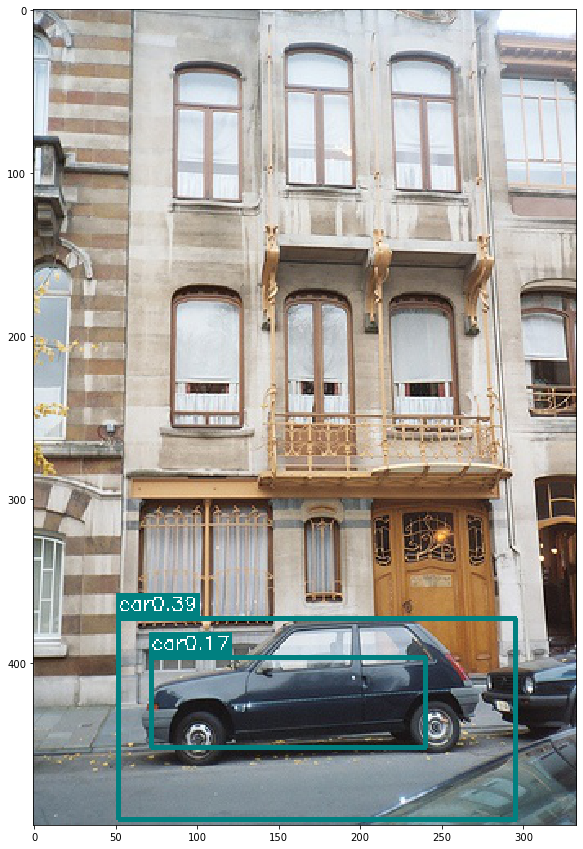

In [15]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [13]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:50<00:00, 28.99it/s]


---class aeroplane ap 0.4881660348523512---
---class bicycle ap 0.5910790120637595---
---class bird ap 0.5269260222737131---
---class boat ap 0.280639712575152---
---class bottle ap 0.19019782593302492---
---class bus ap 0.6036374401085959---
---class car ap 0.6709786011883403---
---class cat ap 0.7229814112610763---
---class chair ap 0.3066197118897297---
---class cow ap 0.5218138913354247---
---class diningtable ap 0.3252092389289864---
---class dog ap 0.6536230598851526---
---class horse ap 0.6899624173806762---
---class motorbike ap 0.5457045457961136---
---class person ap 0.5205615428457908---
---class pottedplant ap 0.19501856387748934---
---class sheep ap 0.47282640423304856---
---class sofa ap 0.48547453683086417---
---class train ap 0.6787375733964629---
---class tvmonitor ap 0.5404103454031093---
---map 0.5005283946029431---


In [14]:
output_submission_csv('my_solution.csv', test_aps)

In [25]:
loc = os.getcwd()

predicting...


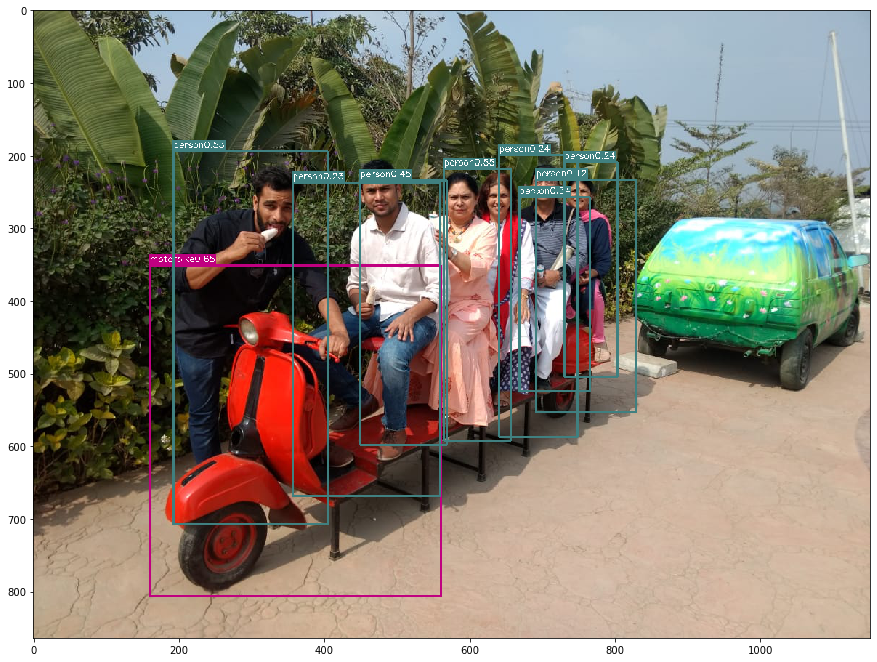

In [35]:
net.eval()


image_name = 'IMG-20200118-WA0023.jpg'
image = cv2.imread(os.path.join(loc, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory='')
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


predicting...


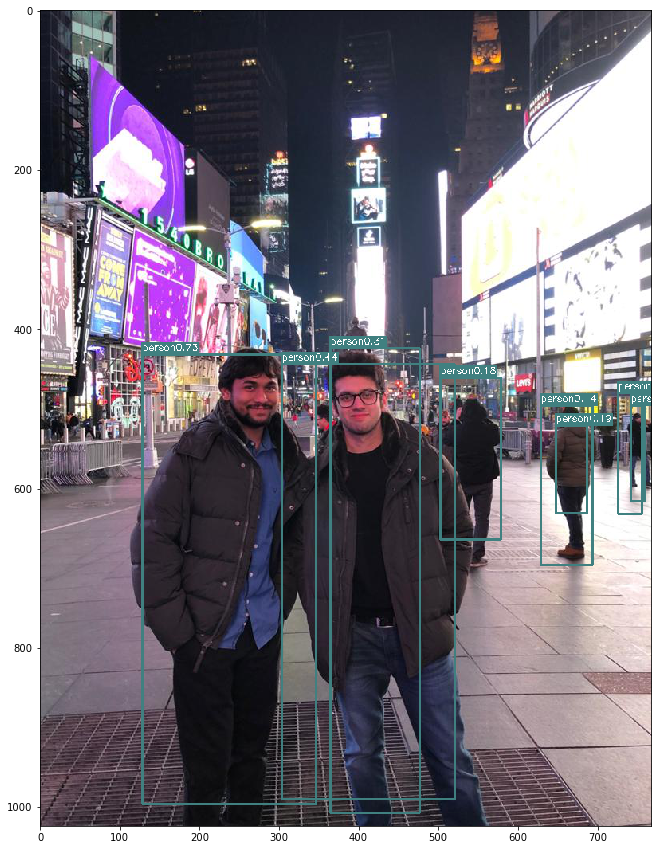

In [36]:
net.eval()


image_name = 'IMG-20200119-WA0020.jpg'
image = cv2.imread(os.path.join(loc, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory='')
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


predicting...


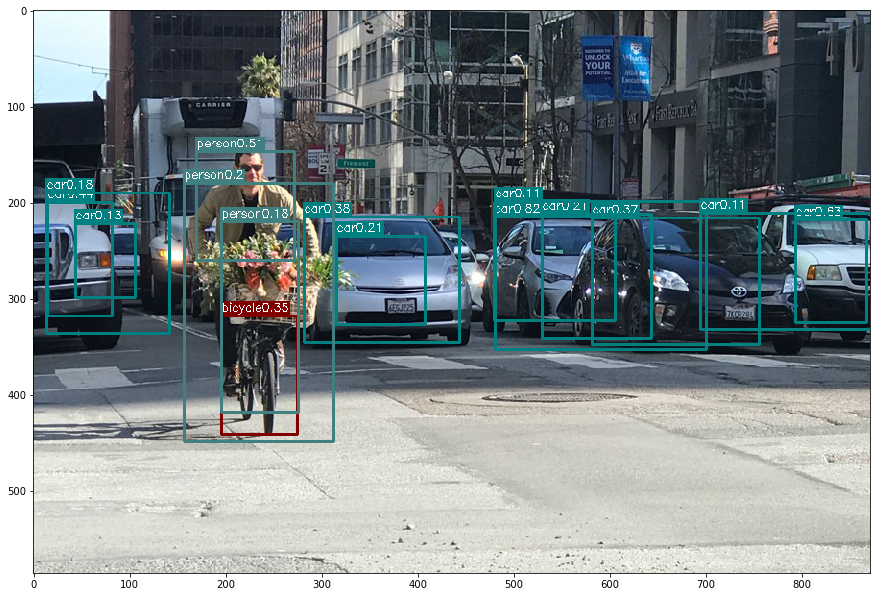

In [37]:
net.eval()


image_name = 'trial.jpeg'
image = cv2.imread(os.path.join(loc, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory='')
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)
